# Predicting Obesity Risk and Identifying Contributing Factors through XAI Techniques

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import shap
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.inspection import PartialDependenceDisplay
import lime
import lime.lime_tabular
import dice_ml

import warnings
warnings.filterwarnings("ignore")

c:\Users\nrohi\anaconda3\envs\env_conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Set Prameters for Reproduciblity
pd.set_option("display.max_rows",100)

TARGET = "ObesityRisk"
n_splits = 10
RANDOM_SEED = 7

# load dataset
data_df = pd.read_csv("obesity_dataset.csv")

In [ ]:
# Data Exploration
# Update the name of columns to make it more understandable

# Define the new column names
new_column_names = {'FAVC': 'highcal_intake',
                    'FCVC': 'veg_intake',
                    'NCP': 'meals_daily',
                    'CAEC': 'snacking',
                    'CH2O': 'water_intake_daily',
                    'SCC': 'track_cal_intake',
                    'FAF': 'physical_weekly',
                    'TUE': 'tech_usage_daily',
                    'CALC': 'alcohol_intake',
                    'MTRANS': 'transport_mode'
                   }

# Rename the columns using the rename() method
data_df.rename(columns=new_column_names, inplace=True)

In [5]:
# View dataframe
print(f"Total number of rows: {len(data_df)}")
print(f"Total number of columns: {data_df.shape[1]}\n")

data_df.head(10)

Total number of rows: 15327
Total number of columns: 19



id  Gender        Age    Height      Weight  \
0   4678    Male  25.000000  1.800000   73.000000   
1  13120  Female  20.000000  1.520000   42.000000   
2  14288  Female  26.000000  1.611462  111.942544   
3   3740  Female  21.624552  1.738836  133.472641   
4   4919    Male  18.424941  1.753349   52.000000   
5   6054    Male  17.000000  1.773664   97.416417   
6   7136  Female  21.000000  1.560000   49.000000   
7   3062    Male  19.000000  1.750000   86.000000   
8   1298    Male  30.958051  1.750000  120.098812   
9   8182  Female  18.000000  1.650000   84.493156   

  family_history_with_overweight highcal_intake veg_intake        meals_daily  \
0                            yes            yes  Sometimes            3 meals   
1                             no             no     Always          1-2 meals   
2                            yes            yes     Always            3 meals   
3                            yes            yes     Always            3 meals   
4                            yes            yes      Never            3 meals   
5                            yes            yes  Sometimes            3 meals   
6                             no            yes  Sometimes            3 meals   
7                            yes            yes     Always  more than 3 meals   
8                            yes            yes  Sometimes            3 meals   
9                            yes            yes  Sometimes            3 meals   

     snacking SMOKE  water_intake_daily track_cal_intake   physical_weekly  \
0  Frequently    no          1-2 litres               no  more than 4 days   
1  Frequently    no   less than 1 litre               no            0 days   
2   Sometimes    no  more than 2 litres               no            0 days   
3   Sometimes    no  more than 2 litres               no          2-4 days   
4   Sometimes    no          1-2 litres               no          1-2 days   
5   Sometimes    no          1-2 litres               no  more than 4 days   
6   Sometimes    no   less than 1 litre               no            0 days   
7      Always    no          1-2 litres               no          2-4 days   
8   Sometimes    no  more than 2 litres               no          1-2 days   
9   Sometimes    no   less than 1 litre               no          1-2 days   

  tech_usage_daily alcohol_intake         transport_mode        BMI  \
0        3-5 hours      Sometimes                Walking  22.530864   
1        0-2 hours      Sometimes  Public_Transportation  18.178670   
2        0-2 hours      Sometimes  Public_Transportation  43.107718   
3        3-5 hours      Sometimes  Public_Transportation  44.144338   
4        3-5 hours             no  Public_Transportation  16.914790   
5        3-5 hours             no  Public_Transportation  30.966309   
6        0-2 hours      Sometimes  Public_Transportation  20.134780   
7        0-2 hours      Sometimes  Public_Transportation  28.081633   
8        0-2 hours      Sometimes  Public_Transportation  39.215939   
9        0-2 hours             no  Public_Transportation  31.035135   

      ObesityRisk  
0   Normal_Weight  
1     Underweight  
2  Obesity_Severe  
3  Obesity_Severe  
4     Underweight  
5         Obesity  
6   Normal_Weight  
7      Overweight  
8  Obesity_Severe  
9         Obesity

In [6]:
# Numerical columns
data_df.describe()

id           Age        Height        Weight           BMI
count  15327.000000  15327.000000  15327.000000  15327.000000  15327.000000
mean   10296.643962     23.281347      1.694663     81.528454     28.232608
std     6004.514805      5.777662      0.088350     25.333116      8.008300
min        0.000000     14.000000      1.450000     39.000000     12.868541
25%     5073.500000     19.000000      1.628232     60.000000     21.736505
50%    10235.000000     21.837996      1.700000     80.000000     27.430560
75%    15518.500000     25.950898      1.758539    104.572712     33.899585
max    20756.000000     61.000000      1.975663    165.057269     54.991071

In [7]:
# Check counts, column dtypes, null and unique count in each Column

tmp = pd.DataFrame(index=data_df.columns)
tmp['count'] = data_df.count()
tmp['dtype'] = data_df.dtypes
tmp['nunique'] = data_df.nunique()
tmp['%nunique'] = (tmp['nunique']/len(data_df))*100
tmp['%null'] = (data_df.isnull().sum()/len(data_df))*100

tmp = tmp.round(3)

display(tmp)
del tmp

count    dtype  nunique  %nunique  %null
id                              15327    int64    15327   100.000    0.0
Gender                          15327   object        2     0.013    0.0
Age                             15327  float64     1555    10.145    0.0
Height                          15327  float64     1715    11.189    0.0
Weight                          15327  float64     1800    11.744    0.0
family_history_with_overweight  15327   object        2     0.013    0.0
highcal_intake                  15327   object        2     0.013    0.0
veg_intake                      15327   object        3     0.020    0.0
meals_daily                     15327   object        3     0.020    0.0
snacking                        15327   object        4     0.026    0.0
SMOKE                           15327   object        2     0.013    0.0
water_intake_daily              15327   object        3     0.020    0.0
track_cal_intake                15327   object        2     0.013    0.0
physical_weekly                 15327   object        4     0.026    0.0
tech_usage_daily                15327   object        3     0.020    0.0
alcohol_intake                  15327   object        3     0.020    0.0
transport_mode                  15327   object        5     0.033    0.0
BMI                             15327  float64     8860    57.806    0.0
ObesityRisk                     15327   object        5     0.033    0.0

In [8]:
# Observe the five unique labels
unique_labels = sorted(data_df['ObesityRisk'].unique())
print(unique_labels)

['Normal_Weight', 'Obesity', 'Obesity_Severe', 'Overweight', 'Underweight']


In [9]:
# Categorise the different features into numerical (continuous), ordinal, binary or categorical

raw_num_cols = ['Age', 'Height', 'Weight', 'BMI']
ordinal_cols = ['veg_intake', 'meals_daily', 'snacking', 'water_intake_daily', 'physical_weekly', 'tech_usage_daily', 'alcohol_intake']
binary_cols = ['Gender', 'family_history_with_overweight', 'highcal_intake', 'SMOKE', 'track_cal_intake']
categorical_cols = ['transport_mode']
raw_cat_cols = binary_cols + categorical_cols + ordinal_cols


In [ ]:
#  Data Visualization
# Observe the Distribution of Target Variables based on Gender

pd.set_option('display.float_format', '{:.2f}'.format)
tmp = pd.DataFrame(data_df.groupby([TARGET, 'Gender'])["id"].agg('count')).reset_index()
tmp.columns.values[2] = 'Count'
tmp = tmp.set_index(TARGET)

tmp = pd.merge(tmp,data_df[TARGET].value_counts(),left_index=True, right_index=True)
tmp.columns.values[1:3] = ['gender_count','target_class_count']
tmp['%gender_count'] = tmp['gender_count']/tmp['target_class_count']
tmp["%target_class_count"] = tmp['target_class_count']/len(data_df)
tmp = tmp[['gender_count','%gender_count','target_class_count','%target_class_count']]

print("Distribution of Target Variables based on Gender:")
display(tmp)
del tmp

Distribution of Target Variables based on Gender:


gender_count  %gender_count  target_class_count  \
Normal_Weight           1660           0.54                3082   
Normal_Weight           1422           0.46                3082   
Obesity                 1267           0.44                2910   
Obesity                 1643           0.56                2910   
Obesity_Severe          1892           0.56                3406   
Obesity_Severe          1514           0.44                3406   
Overweight              1276           0.37                3406   
Overweight              2130           0.63                3406   
Underweight             1621           0.64                2523   
Underweight              902           0.36                2523   

                %target_class_count  
Normal_Weight                  0.20  
Normal_Weight                  0.20  
Obesity                        0.19  
Obesity                        0.19  
Obesity_Severe                 0.22  
Obesity_Severe                 0.22  
Overweight                     0.22  
Overweight                     0.22  
Underweight                    0.16  
Underweight                    0.16

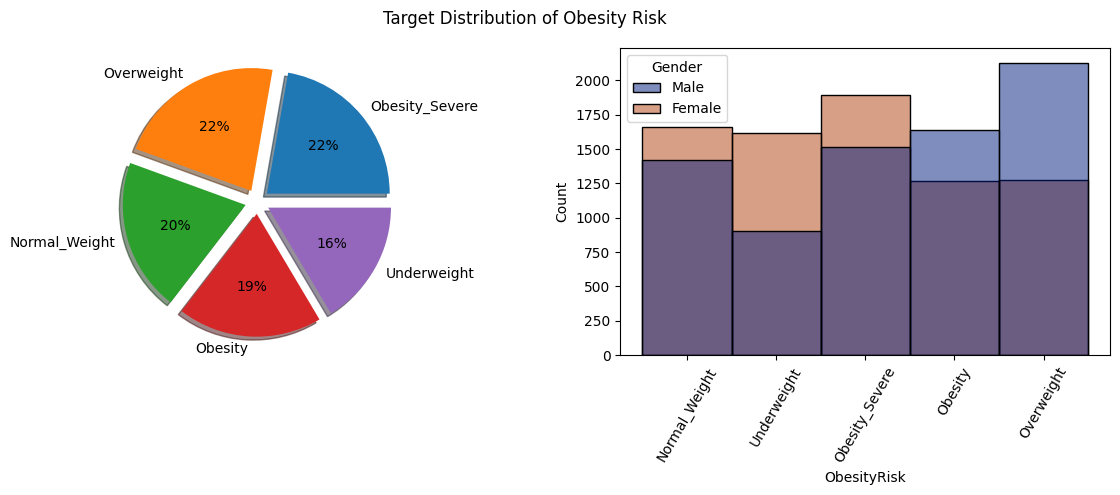

In [11]:
fig, axs = plt.subplots(1,2,figsize = (12,5))
plt.suptitle("Target Distribution of Obesity Risk")

axs[0].pie(
        data_df[TARGET].value_counts(),
        shadow = True,
        explode=[.1 for i in range(data_df[TARGET].nunique())],
        labels = data_df[TARGET].value_counts().index,
        autopct='%1.f%%',
    )

sns.histplot(binwidth=0.5,x=TARGET,data=data_df,hue='Gender',palette="dark",ax=axs[1],discrete=True)
axs[1].tick_params(axis='x', rotation=60)

plt.tight_layout()
plt.show()

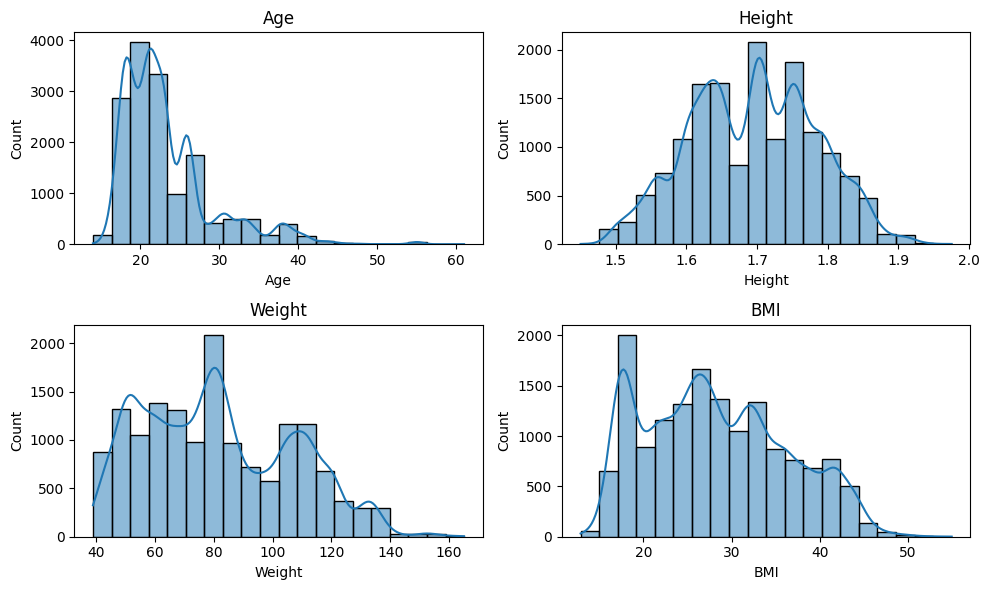

In [12]:
# Create a 2x2 plot for histograms
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

# Flatten the axis array to loop through the axes
axs = axs.flatten()

# Loop through numerical columns and plot histograms
for i, col in enumerate(raw_num_cols):
    # Plot histogram for each column
    sns.histplot(data_df[col], ax=axs[i], bins=20, kde=True, stat='count')  # Adjust the number of bins as needed
    axs[i].set_title(col)
    # axs[i].grid(False)  # Remove grid lines

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

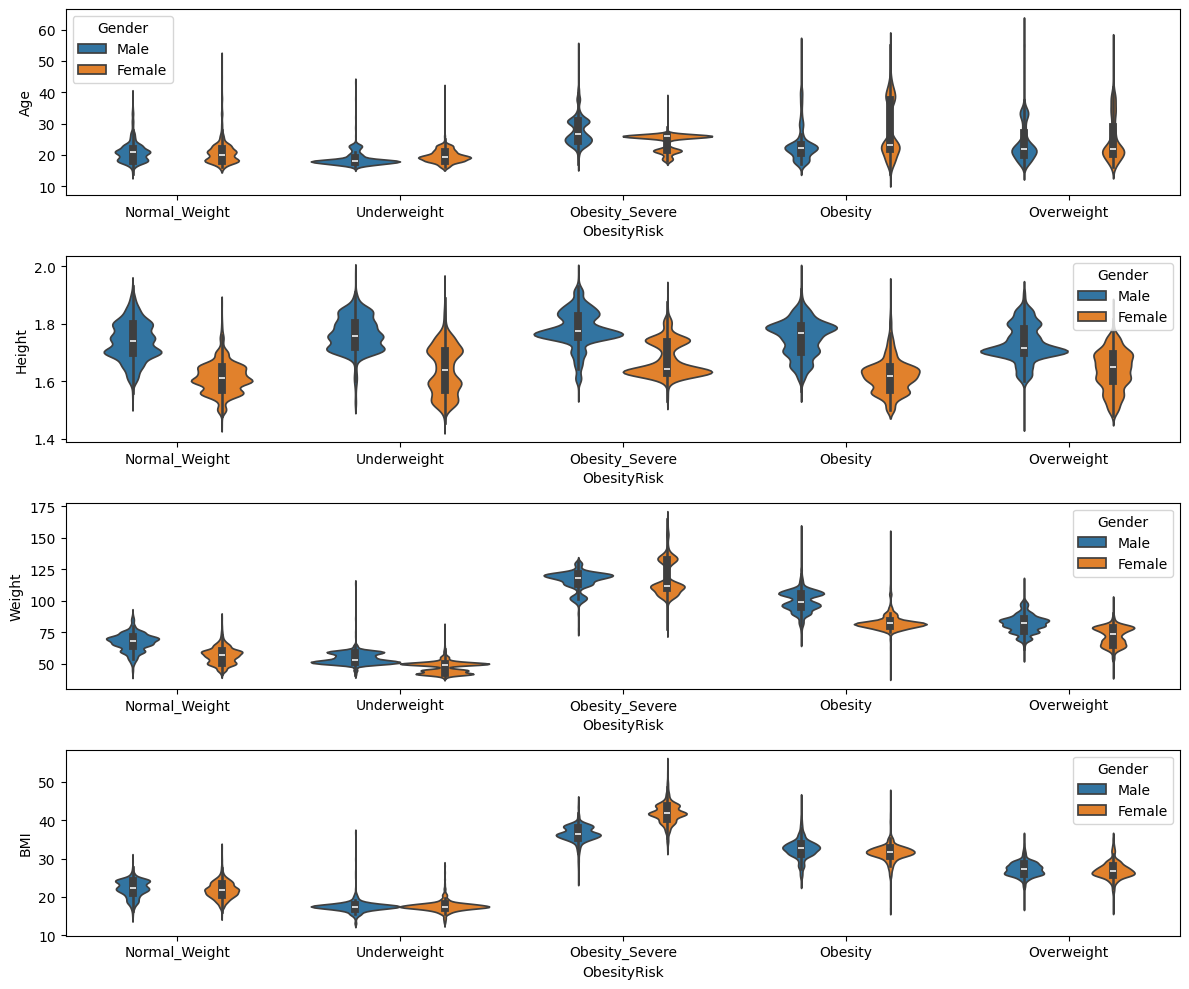

In [13]:
fig,axs = plt.subplots(len(raw_num_cols),1,figsize=(12,len(raw_num_cols)*2.5),sharex=False)

for i, col in enumerate(raw_num_cols):
    sns.violinplot(x=TARGET, y=col,hue="Gender", data=data_df,ax = axs[i], split=False)

plt.tight_layout()
plt.show()

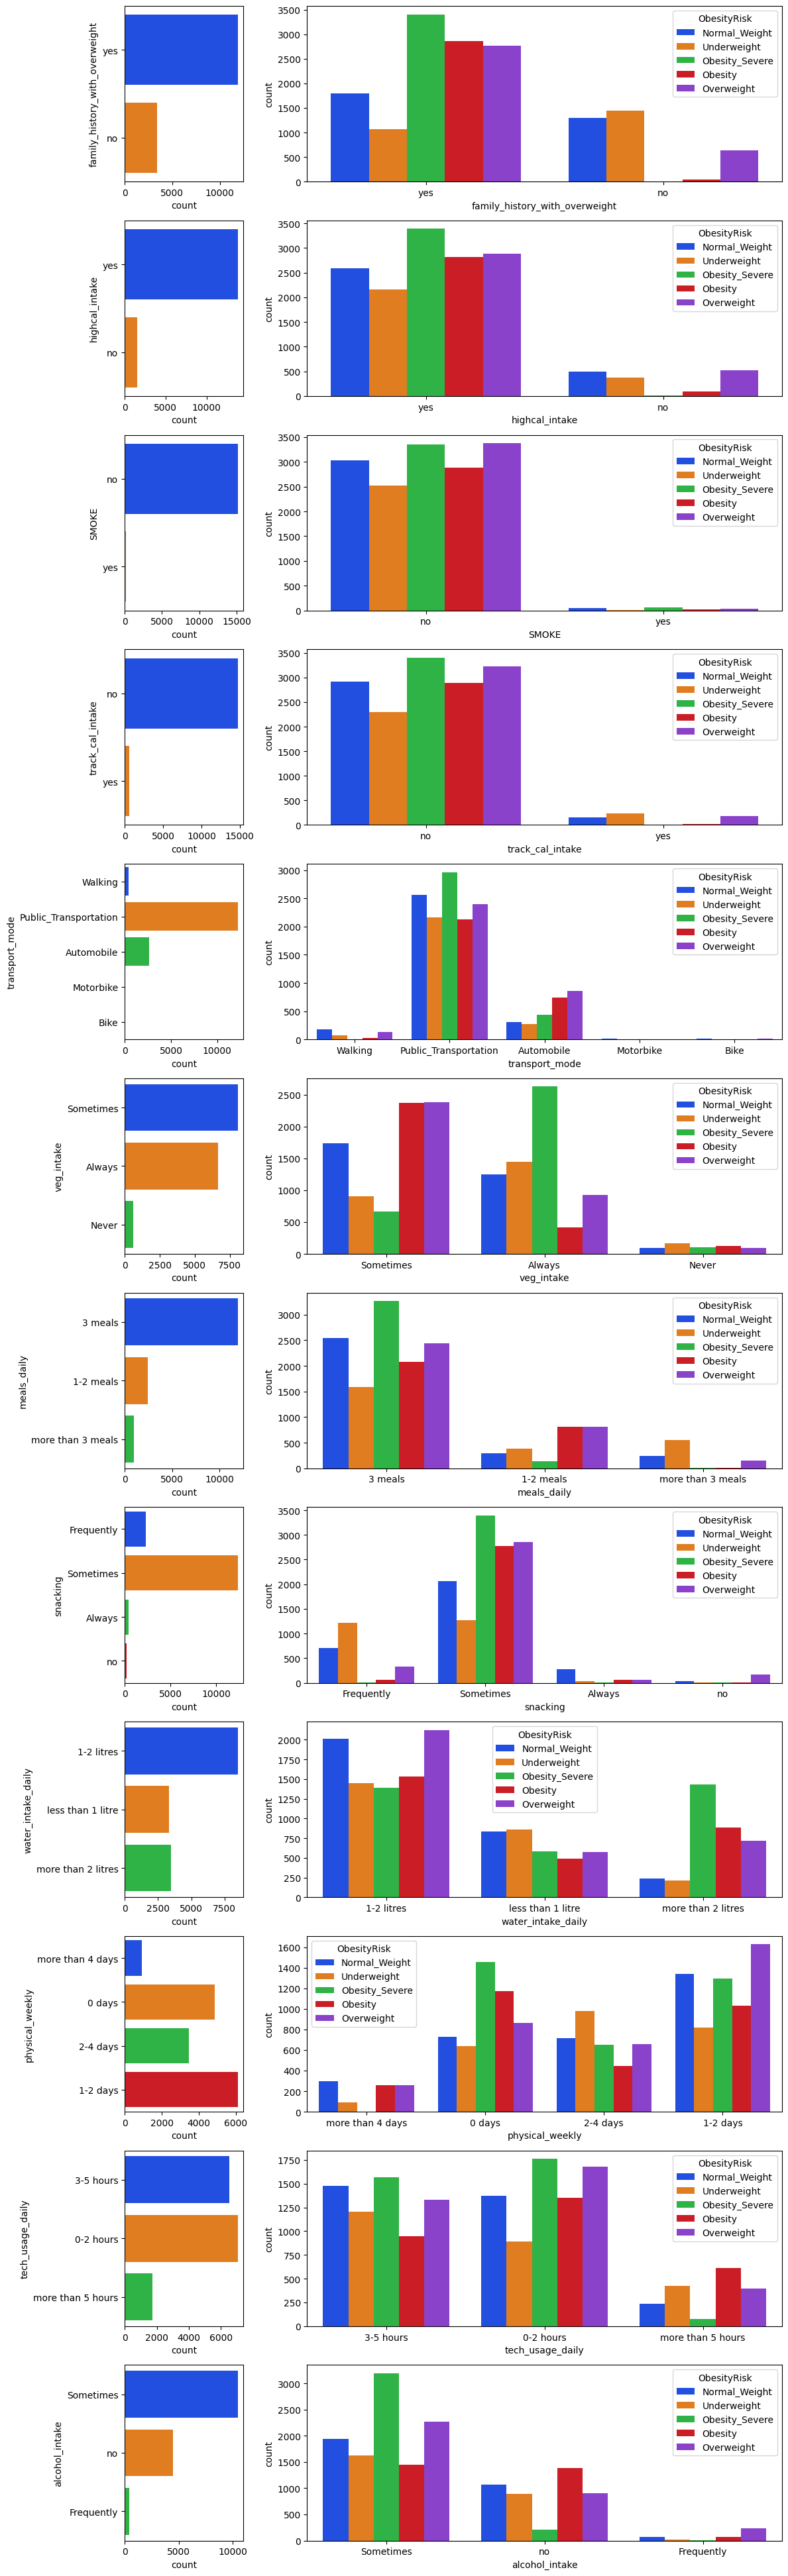

In [14]:
_,axs = plt.subplots(int(len(raw_cat_cols)-1),2,figsize=(12,len(raw_cat_cols)*3),width_ratios=[1, 4])
for i,col in enumerate(raw_cat_cols[1:]):
    sns.countplot(y=col,data=data_df,palette="bright",ax=axs[i,0])
    sns.countplot(x=col,data=data_df,hue=TARGET,palette="bright",ax=axs[i,1])

plt.tight_layout()
plt.show()

In [ ]:
# Pearson Correlation Plot (for numerical features)
data_df[raw_num_cols].corr("pearson")

Age  Height  Weight  BMI
Age     1.00   -0.05    0.30 0.36
Height -0.05    1.00    0.41 0.10
Weight  0.30    0.41    1.00 0.94
BMI     0.36    0.10    0.94 1.00

<Axes: >

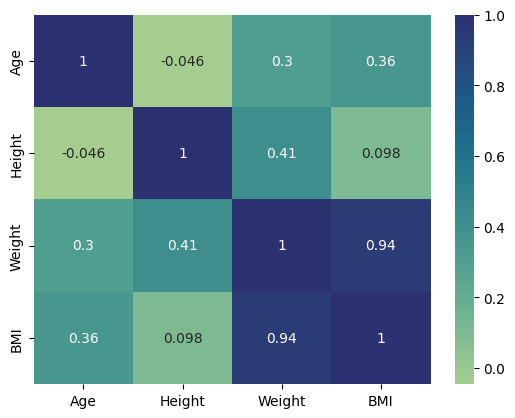

In [16]:
corr_matrix = data_df[raw_num_cols].corr("pearson")
sns.heatmap(corr_matrix, annot=True, cmap ="crest")

In [ ]:
# Feature Engineering & Processing
# Types of variables
numerical_cols = ['Age']  # 'Height', 'Weight', 'BMI'
ordinal_cols = ['veg_intake', 'meals_daily', 'snacking', 'water_intake_daily', 'physical_weekly', 'tech_usage_daily', 'alcohol_intake']
binary_cols = ['Gender', 'family_history_with_overweight', 'highcal_intake', 'SMOKE', 'track_cal_intake']
categorical_cols = ['transport_mode']
onehot_cols = binary_cols + categorical_cols

In [18]:
# Define the encoders
ordinal = OrdinalEncoder(categories = [
                            ['Never', 'Sometimes', 'Always'], # veg_intake
                            ['1-2 meals', '3 meals', 'more than 3 meals'], # meals_daily
                            ['no', 'Sometimes', 'Frequently', 'Always'], # snacking
                            ['less than 1 litre', '1-2 litres', 'more than 2 litres'], # water_intake_daily
                            ['0 days', '1-2 days', '2-4 days', 'more than 4 days'], # physical_weekly
                            ['0-2 hours', '3-5 hours', 'more than 5 hours'], # tech_usage_daily
                            ['no', 'Sometimes', 'Frequently'] # alcohol_intake
                         ],
                         handle_unknown = 'use_encoded_value',
                         unknown_value = -1
                        )

onehot = OneHotEncoder(categories = [
                            ['Female', 'Male'], # Gender
                            ['no', 'yes'], # family_history_with_overweight
                            ['no', 'yes'], # highcal_intake
                            ['no', 'yes'], # SMOKE
                            ['no', 'yes'], # track_cal_intake
                            ['Walking', 'Public_Transportation', 'Automobile', 'Motorbike', 'Bike'] # transport_mode
                         ],
                         handle_unknown = 'ignore',
                        )

# Combine them!
encoder = ColumnTransformer([
   # List of (name, transformer, columns) tuples specifying the transformer objects to be applied to subsets of the data.
    ('numerical', 'passthrough', numerical_cols),   # <- 'passthrough' says to keep them but don't apply anything
    ('ordinal', ordinal, ordinal_cols),             # <- apply ordinal encoder to the ordinal_columns
    ('onehot', onehot, onehot_cols)                 # <- apply onehot encoder to the onehot_columns
])

encoder

ColumnTransformer(transformers=[('numerical', 'passthrough', ['Age']),
                                ('ordinal',
                                 OrdinalEncoder(categories=[['Never',
                                                             'Sometimes',
                                                             'Always'],
                                                            ['1-2 meals',
                                                             '3 meals',
                                                             'more than 3 '
                                                             'meals'],
                                                            ['no', 'Sometimes',
                                                             'Frequently',
                                                             'Always'],
                                                            ['less than 1 '
                                                             'litre',
                                                             '1-2 litres',
                                                             'more than 2 '
                                                             'litres'],
                                                            ['0 days',
                                                             '1-2 days',
                                                             '2-4 days',
                                                             'more than 4 '
                                                             'days'],
                                                            ['0-2 hours',
                                                             '3-5 hours',
                                                             'more th...
                                  'water_intake_daily', 'physical_weekly',
                                  'tech_usage_daily', 'alcohol_intake']),
                                ('onehot',
                                 OneHotEncoder(categories=[['Female', 'Male'],
                                                           ['no', 'yes'],
                                                           ['no', 'yes'],
                                                           ['no', 'yes'],
                                                           ['no', 'yes'],
                                                           ['Walking',
                                                            'Public_Transportation',
                                                            'Automobile',
                                                            'Motorbike',
                                                            'Bike']],
                                               handle_unknown='ignore'),
                                 ['Gender', 'family_history_with_overweight',
                                  'highcal_intake', 'SMOKE', 'track_cal_intake',
                                  'transport_mode'])])

In [19]:
# Define the label mapping dictionary
label_mapping = {
    'Underweight': 0,
    'Normal_Weight': 1,
    'Overweight': 2,
    'Obesity': 3,
    'Obesity_Severe': 4
}

# Map the labels to integers
data_df['ObesityRisk'] = data_df['ObesityRisk'].map(label_mapping)

print(data_df['ObesityRisk'].unique())

[1 0 4 3 2]


## 4.1 Train Test Split

In [20]:
# Separate target variable & features
X = data_df.drop(columns = ['id','ObesityRisk', 'Height', 'Weight', 'BMI'])  #'Height', 'Weight', 'BMI'
y = data_df['ObesityRisk']

print(X.shape, y.shape)

(15327, 14) (15327,)


In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7, stratify = y)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(12261, 14) (3066, 14) (12261,) (3066,)


In [22]:
print(y_train.head())
X_train.head()

13870    0
8962     1
12769    1
6937     1
5628     3
Name: ObesityRisk, dtype: int64


Gender   Age family_history_with_overweight highcal_intake veg_intake  \
13870  Female 19.00                             no            yes  Sometimes   
8962     Male 22.00                             no            yes  Sometimes   
12769  Female 23.00                            yes            yes  Sometimes   
6937     Male 23.00                            yes             no      Never   
5628     Male 21.01                            yes            yes     Always   

             meals_daily    snacking SMOKE water_intake_daily  \
13870            3 meals   Sometimes    no  less than 1 litre   
8962             3 meals   Sometimes    no  less than 1 litre   
12769            3 meals   Sometimes    no         1-2 litres   
6937   more than 3 meals  Frequently    no         1-2 litres   
5628             3 meals   Sometimes    no         1-2 litres   

      track_cal_intake physical_weekly   tech_usage_daily alcohol_intake  \
13870               no        1-2 days          3-5 hours      Sometimes   
8962               yes          0 days  more than 5 hours             no   
12769               no          0 days          3-5 hours      Sometimes   
6937                no        2-4 days          3-5 hours      Sometimes   
5628                no        1-2 days          3-5 hours      Sometimes   

              transport_mode  
13870  Public_Transportation  
8962   Public_Transportation  
12769  Public_Transportation  
6937   Public_Transportation  
5628   Public_Transportation

In [ ]:
# Machine Learning Modelling
# Create a Logistic Regression model
lr = LogisticRegression(
    class_weight='balanced', # ensure balanced weights to account for class imbalance
    random_state=7,
    max_iter=1000
)

# Initialise standard scaler
scaler = StandardScaler()

pipe_lr =  Pipeline([
    ('encoder', encoder),
    ('scaler', scaler),
    ('lr', lr)
])

# Parameters to search over
param_grid = {
    'lr__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'lr__penalty': [None, 'l1', 'l2']  # Penalty term
}

### Validator ###
# Use 5 k-fold, considering the size of the dataset & computational power
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

## GridSearch ###
grid = GridSearchCV(pipe_lr,       # model to use
                    param_grid, # parameters to search over
                    scoring = ['balanced_accuracy', 'f1_weighted'], # metrics to compute
                    refit = 'f1_weighted',  # which metric to use to decide the best model
                    cv = cv,
                    n_jobs = -1
                   )

grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=7, shuffle=True),
             estimator=Pipeline(steps=[('encoder',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         'passthrough',
                                                                         ['Age']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(categories=[['Never',
                                                                                                     'Sometimes',
                                                                                                     'Always'],
                                                                                                    ['1-2 '
                                                                                                     'meals',
                                                                                                     '3 '
                                                                                                     'meals',
                                                                                                     'more '
                                                                                                     'than '
                                                                                                     '3 '
                                                                                                     'meals'],
                                                                                                    ['no',
                                                                                                     'Sometimes',
                                                                                                     'Frequently',
                                                                                                     'Always'],
                                                                                                    ['less '
                                                                                                     'than '
                                                                                                     '...
                                                                          'family_history_with_overweight',
                                                                          'highcal_intake',
                                                                          'SMOKE',
                                                                          'track_cal_intake',
                                                                          'transport_mode'])])),
                                       ('scaler', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           random_state=7))]),
             n_jobs=-1,
             param_grid={'lr__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'lr__penalty': [None, 'l1', 'l2']},
             refit='f1_weighted', scoring=['balanced_accuracy', 'f1_weighted'])

In [24]:
print(grid.best_params_)
print(grid.best_score_)

{'lr__C': 1, 'lr__penalty': 'l2'}
0.5435597407828754


In [25]:
# Create a Random Forest model with balanced class weights
rfc = RandomForestClassifier(
    n_estimators = 100,  # default
    max_features='sqrt',
    # max_depth= ?, # to optimise
    # max_leaf_nodes = ?,  # to optimise
    # min_samples_split = ? # to optimise
    class_weight='balanced', # ensure balanced weights to account for class imbalance
    random_state=7)

pipe_rfc =  Pipeline([
    ('encoder', encoder),
    ('rfc', rfc)
])

### Parameters to search over ###
param_grid = {
    'rfc__max_depth': [8, 10, 12, 14, 16, 18, 20, 25],
    'rfc__max_leaf_nodes': [50, 75, 100, 125, 150, 200, 250, 300],
    'rfc__min_samples_split': [50, 75, 100, 150, 200]
}

### Validator ###
# Use 5 k-fold, considering the size of the dataset & computational power
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

## GridSearch ###
grid = GridSearchCV(pipe_rfc,       # model to use
                    param_grid, # parameters to search over
                    scoring = ['balanced_accuracy', 'f1_weighted'], # metrics to compute
                    refit = 'f1_weighted',  # which metric to use to decide the best model
                    cv = cv,
                    n_jobs = -1
                   )

grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=7, shuffle=True),
             estimator=Pipeline(steps=[('encoder',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         'passthrough',
                                                                         ['Age']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(categories=[['Never',
                                                                                                     'Sometimes',
                                                                                                     'Always'],
                                                                                                    ['1-2 '
                                                                                                     'meals',
                                                                                                     '3 '
                                                                                                     'meals',
                                                                                                     'more '
                                                                                                     'than '
                                                                                                     '3 '
                                                                                                     'meals'],
                                                                                                    ['no',
                                                                                                     'Sometimes',
                                                                                                     'Frequently',
                                                                                                     'Always'],
                                                                                                    ['less '
                                                                                                     'than '
                                                                                                     '...
                                                                          'SMOKE',
                                                                          'track_cal_intake',
                                                                          'transport_mode'])])),
                                       ('rfc',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=7))]),
             n_jobs=-1,
             param_grid={'rfc__max_depth': [8, 10, 12, 14, 16, 18, 20, 25],
                         'rfc__max_leaf_nodes': [50, 75, 100, 125, 150, 200,
                                                 250, 300],
                         'rfc__min_samples_split': [50, 75, 100, 150, 200]},
             refit='f1_weighted', scoring=['balanced_accuracy', 'f1_weighted'])

In [26]:
print(grid.best_params_)
print(grid.best_score_)

{'rfc__max_depth': 20, 'rfc__max_leaf_nodes': 300, 'rfc__min_samples_split': 50}
0.683259240651042


In [27]:
# Define parameter grid for grid search
param_grid = {
    'xgb__learning_rate': [0.01, 0.05, 0.1, 0.3],  # Boosting learning rate
    'xgb__max_depth': [3, 5, 7],  # Maximum tree depth for base learners
    'xgb__subsample': [0.5, 0.6, 0.75, 0.9, 1.0],  # Subsample ratio of the training instance
    'xgb__reg_lambda': [0, 0.1, 0.5, 1],  # L2 regularization term on weights
    'xgb__reg_alpha': [0, 0.1, 0.5, 1]  # L1 regularization term on weights
}

# Create an XGBoost model with scale_pos_weight
xgb = XGBClassifier(booster='gbtree', random_state=7)   # scale_pos_weight=balanced_weights,

pipe_rfc =  Pipeline([
    ('encoder', encoder),
    ('xgb', xgb)
])

### Validator ###
# Use 3 k-fold, considering the size of the dataset & computational power
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)

## GridSearch ###
grid = RandomizedSearchCV(pipe_rfc,       # model to use
                    param_grid, # parameters to search over
                    scoring = ['balanced_accuracy', 'f1_weighted'], # metrics to compute
                    refit = 'f1_weighted',  # which metric to use to decide the best model
                    cv = cv,
                    n_jobs = -1,
                    n_iter = 500
                   )

grid.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=7, shuffle=True),
                   estimator=Pipeline(steps=[('encoder',
                                              ColumnTransformer(transformers=[('numerical',
                                                                               'passthrough',
                                                                               ['Age']),
                                                                              ('ordinal',
                                                                               OrdinalEncoder(categories=[['Never',
                                                                                                           'Sometimes',
                                                                                                           'Always'],
                                                                                                          ['1-2 '
                                                                                                           'meals',
                                                                                                           '3 '
                                                                                                           'meals',
                                                                                                           'more '
                                                                                                           'than '
                                                                                                           '3 '
                                                                                                           'meals'],
                                                                                                          ['no',
                                                                                                           'Sometimes',
                                                                                                           'Frequently',
                                                                                                           'Always'],
                                                                                                          ['less '
                                                                                                           '...
                                                            multi_strategy=None,
                                                            n_estimators=None,
                                                            n_jobs=None,
                                                            num_parallel_tree=None, ...))]),
                   n_iter=500, n_jobs=-1,
                   param_distributions={'xgb__learning_rate': [0.01, 0.05, 0.1,
                                                               0.3],
                                        'xgb__max_depth': [3, 5, 7],
                                        'xgb__reg_alpha': [0, 0.1, 0.5, 1],
                                        'xgb__reg_lambda': [0, 0.1, 0.5, 1],
                                        'xgb__subsample': [0.5, 0.6, 0.75, 0.9,
                                                           1.0]},
                   refit='f1_weighted',
                   scoring=['balanced_accuracy', 'f1_weighted'])

In [28]:
print(grid.best_params_)
print(grid.best_score_)

{'xgb__subsample': 0.9, 'xgb__reg_lambda': 0, 'xgb__reg_alpha': 1, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.1}
0.7170946840050001


Training & Evaluating the Best XGB Model

```
# Best hyperparams
{'xgb__subsample': 0.6, 'xgb__reg_lambda': 1, 'xgb__reg_alpha': 0.5, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.1}
0.7172519648737294

```

In [29]:
# Evaluate best model based on the tuned hyperparameters

# Create an XGBoost model
xgb = XGBClassifier(booster='gbtree', learning_rate=0.1, max_depth=7, subsample=0.6, reg_lambda=1, reg_alpha=0.5, random_state=7)

pipe_xgb =  Pipeline([
    ('encoder', encoder),
    ('xgb', xgb)
])

pipe_xgb.fit(X_train, y_train)

y_pred = pipe_xgb.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.74      0.75       505
           1       0.63      0.65      0.64       617
           2       0.61      0.54      0.57       681
           3       0.68      0.69      0.69       582
           4       0.86      0.94      0.90       681

    accuracy                           0.71      3066
   macro avg       0.71      0.71      0.71      3066
weighted avg       0.71      0.71      0.71      3066



<Figure size 1000x800 with 0 Axes>

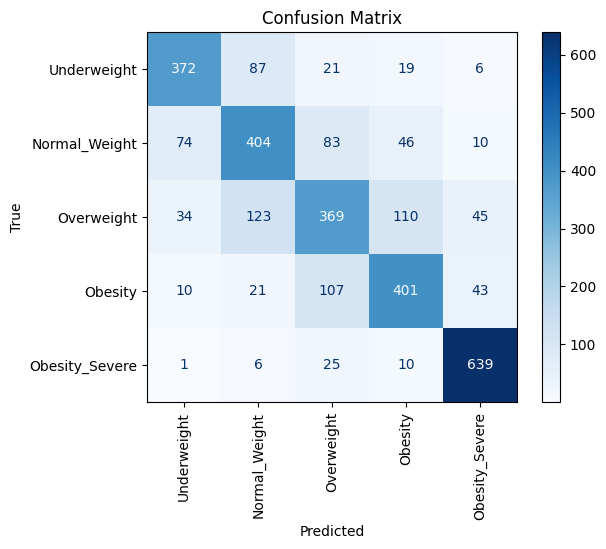

In [30]:
# Define class labels
class_labels_num = [0, 1, 2, 3, 4]
class_labels = ['Underweight', 'Normal_Weight', 'Overweight', 'Obesity', 'Obesity_Severe']

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=class_labels_num)

# Create ConfusionMatrixDisplay
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
cm_display.plot(cmap='Blues', xticks_rotation='vertical', values_format='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

 Permutation Feature Importance (PFI)


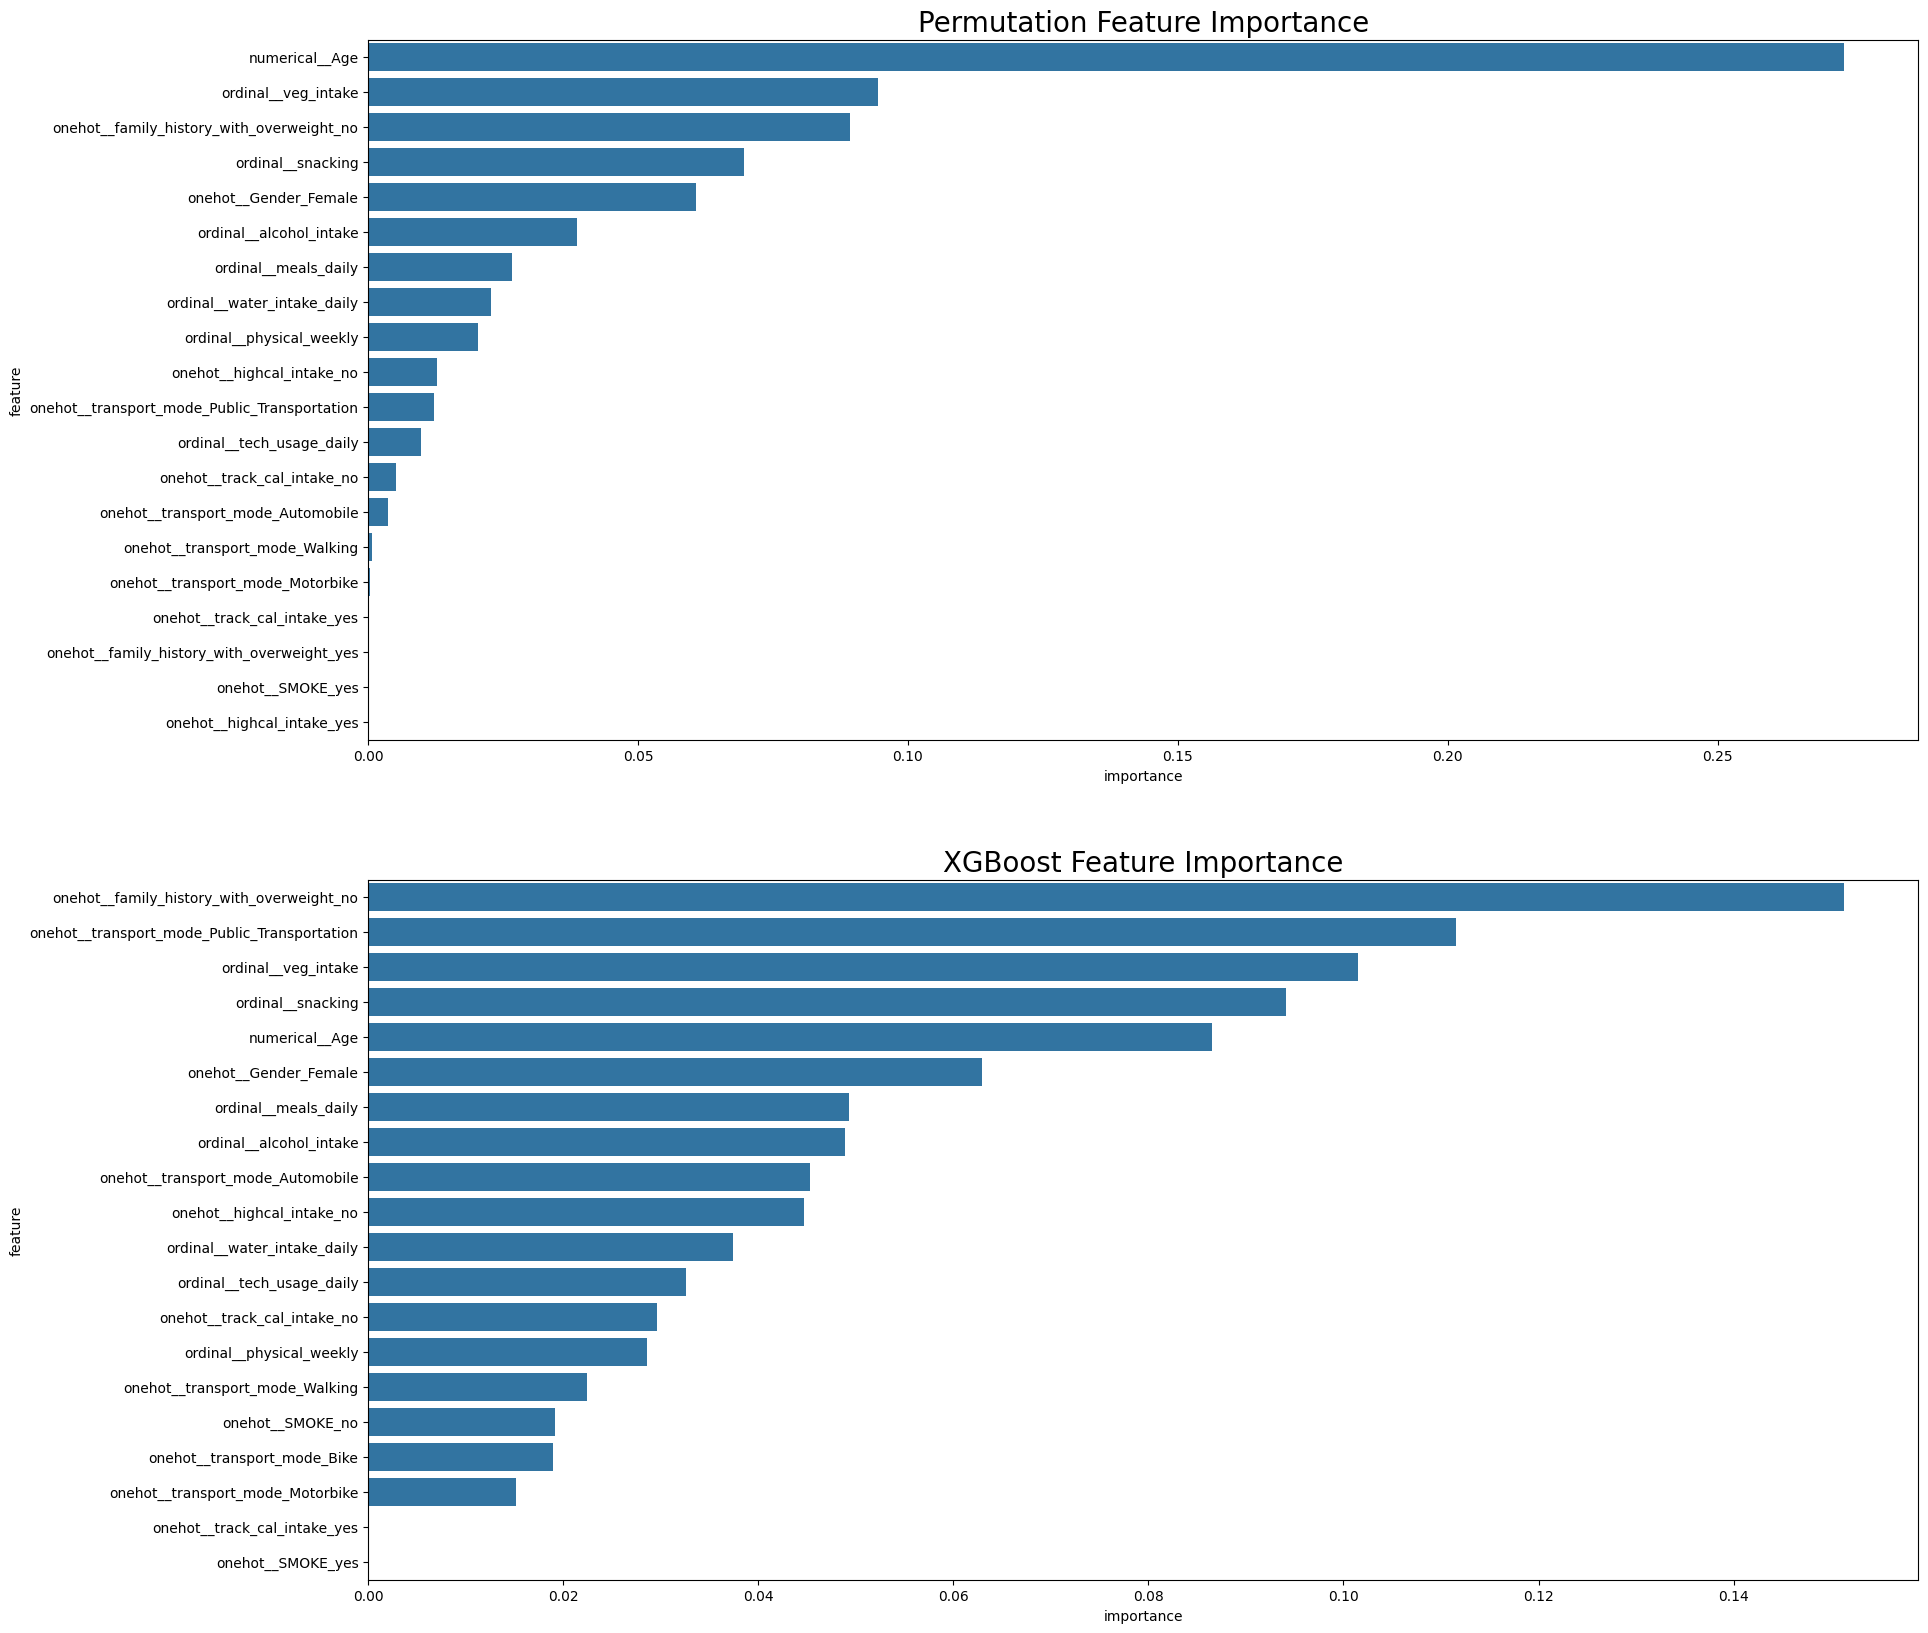

In [31]:
# Get the feature names from the encoder
feature_names = pipe_xgb.named_steps['encoder'].get_feature_names_out()

# Ensure test data is encoded using the same encoder
X_test_encoded = pipe_xgb.named_steps['encoder'].transform(X_test)

# Permutation Feature Importance
perm = PermutationImportance(pipe_xgb.named_steps['xgb'], random_state=7).fit(X_test_encoded, y_test)

# Store Permutation feature importance details in the dataframe for further analysis
perm_df = pd.DataFrame()
perm_df["feature"] = feature_names  # Use the feature names obtained from the encoder
perm_df["importance"] = perm.feature_importances_

# XGB Default Feature Importance
xgb_feature_importance_df = pd.DataFrame()
xgb_feature_importance_df["feature"] = feature_names
xgb_feature_importance_df["importance"] = pipe_xgb.named_steps['xgb'].feature_importances_

# Plot PFI chart
fig, axes = plt.subplots(2, 1, figsize=(20, 20))
plt.rcParams.update({'font.size': 12})

# Permutation Feature Importance
perm_feature_importance_df = perm_df.sort_values('importance', ascending=False).reset_index()
sns.barplot(x='importance', y='feature', data=perm_feature_importance_df[:20], ax=axes[0])
axes[0].set_title("Permutation Feature Importance", fontsize=20)

# Random Forest Default Feature Importance
feature_importance_df = xgb_feature_importance_df.sort_values('importance', ascending=False).reset_index()
sns.barplot(x='importance', y='feature', data=feature_importance_df[:20], ax=axes[1])
axes[1].set_title("XGBoost Feature Importance", fontsize=20)

# Visualize results
eli5.show_weights(perm, feature_names=feature_names)


**XGBoost Feature Importance Key Highlights**

XAI (Global): SHAP


In [32]:
# Transform X_test using the pipeline
transformed_X_test_xgb = pipe_xgb.named_steps['encoder'].transform(X_test)

# Get the feature names from the encoder
feature_names_xgb = pipe_xgb.named_steps['encoder'].get_feature_names_out()

explainer_xgb = shap.TreeExplainer(pipe_xgb.named_steps['xgb'])
shap_values_xgb = explainer_xgb.shap_values(transformed_X_test_xgb)

In [33]:
print(transformed_X_test_xgb.shape)
print(shap_values_xgb.shape) # 1 for each label

(3066, 23)
(3066, 23, 5)


The code below plots the SHAP values for each label category. However, we will focus on the SHAP values for that of the  *normal weight* class.

SHAP Values of Target: <Underweight>


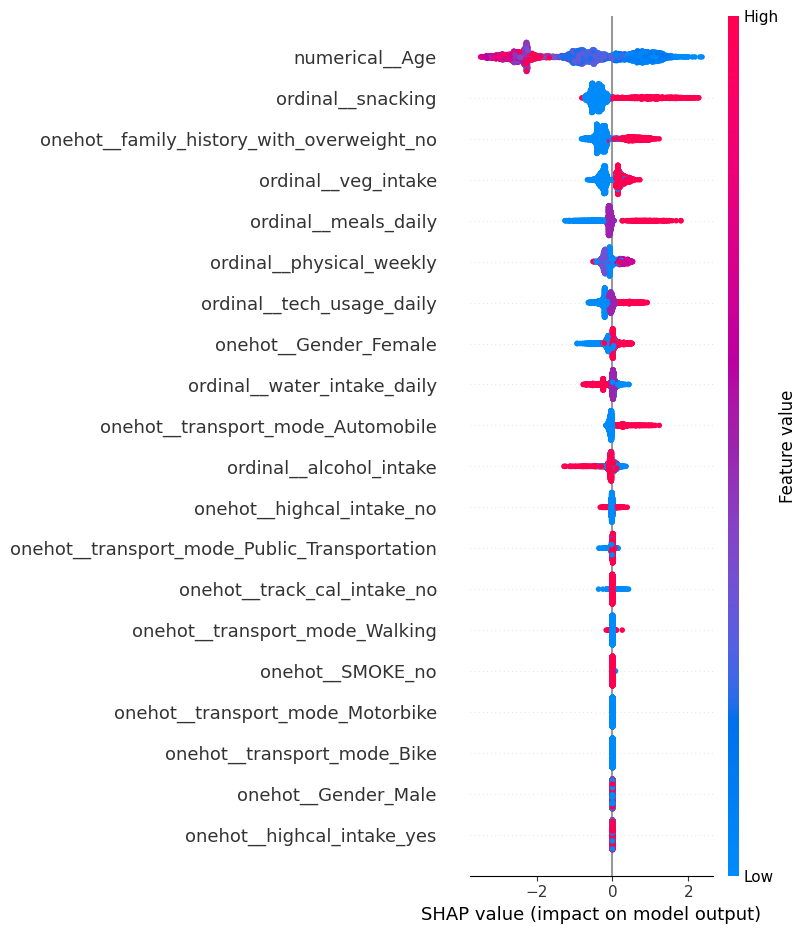

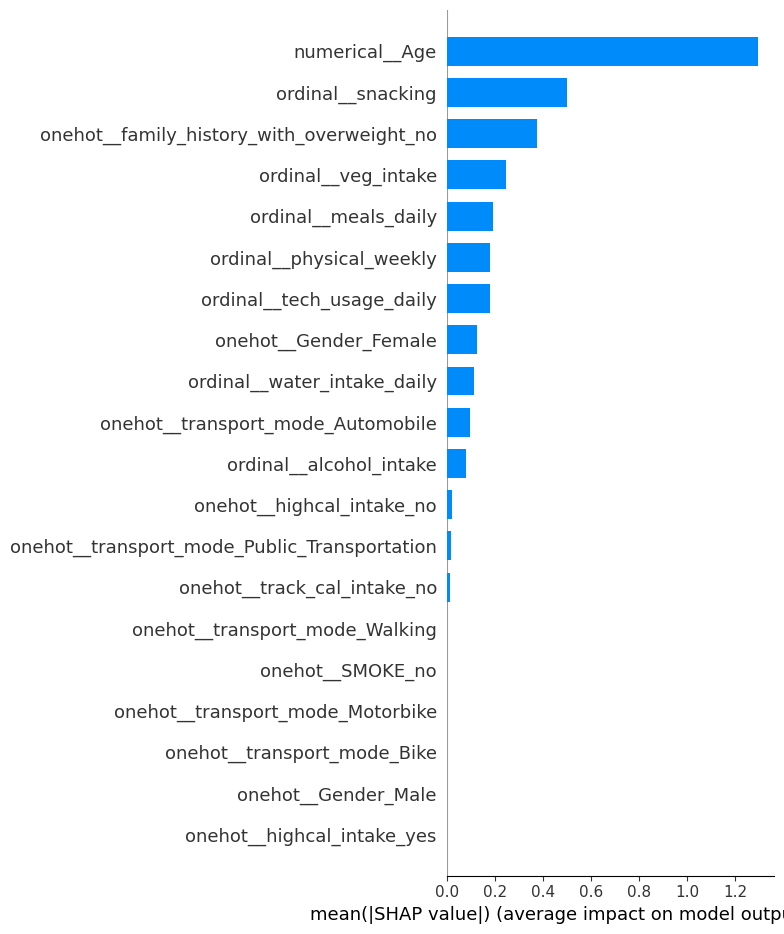

 
SHAP Values of Target: <Normal_Weight>


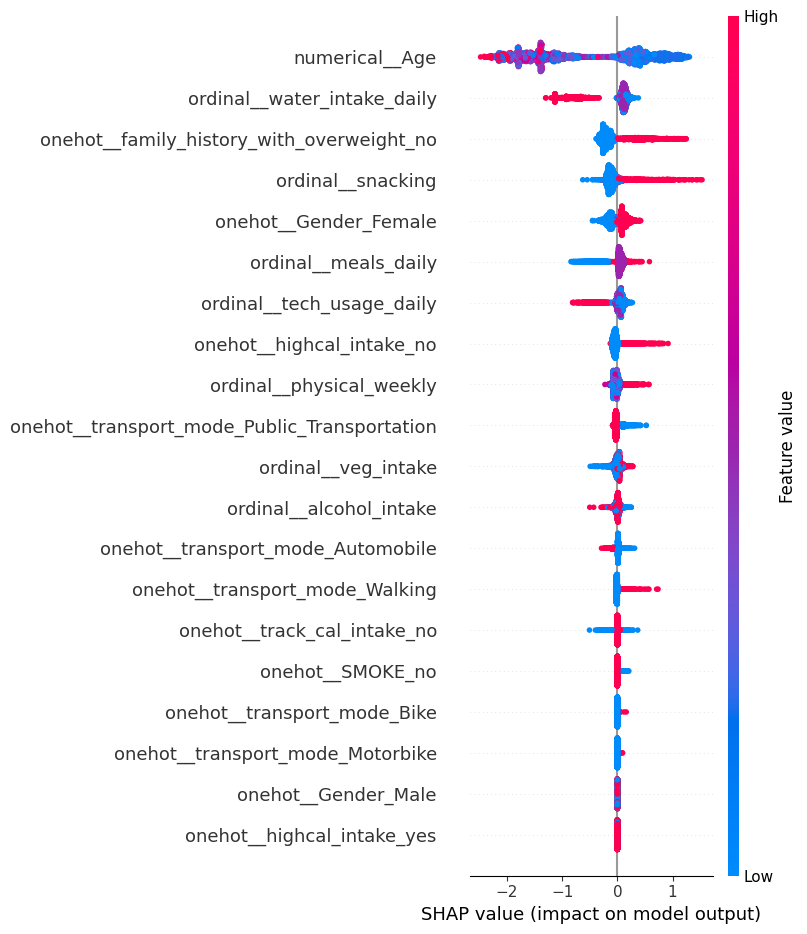

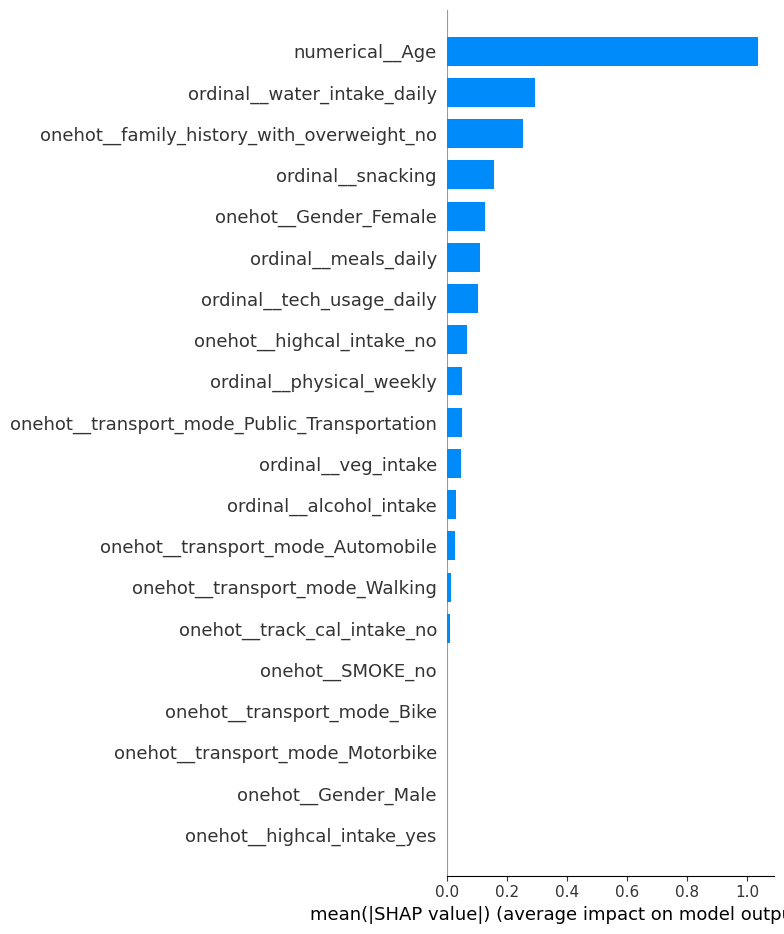

 
SHAP Values of Target: <Overweight>


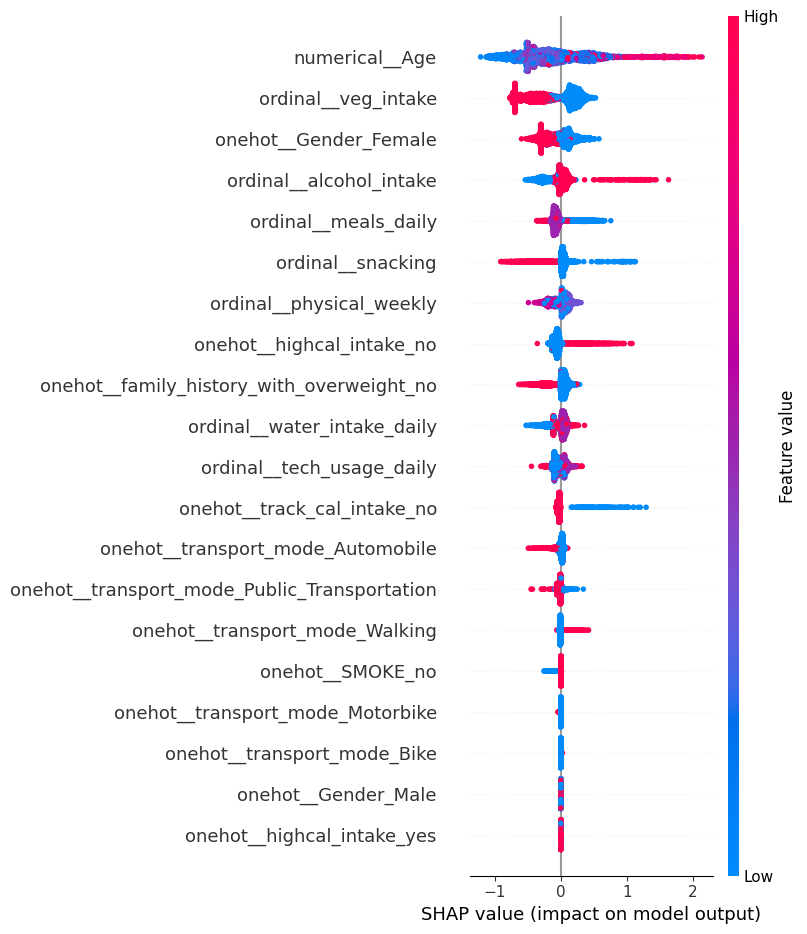

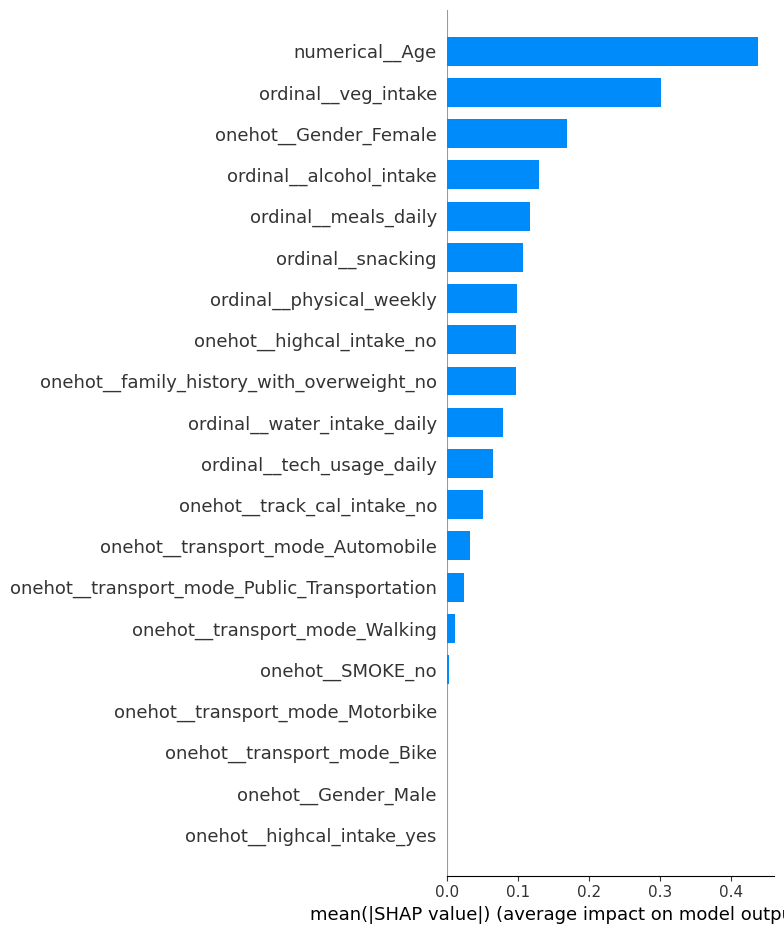

 
SHAP Values of Target: <Obesity>


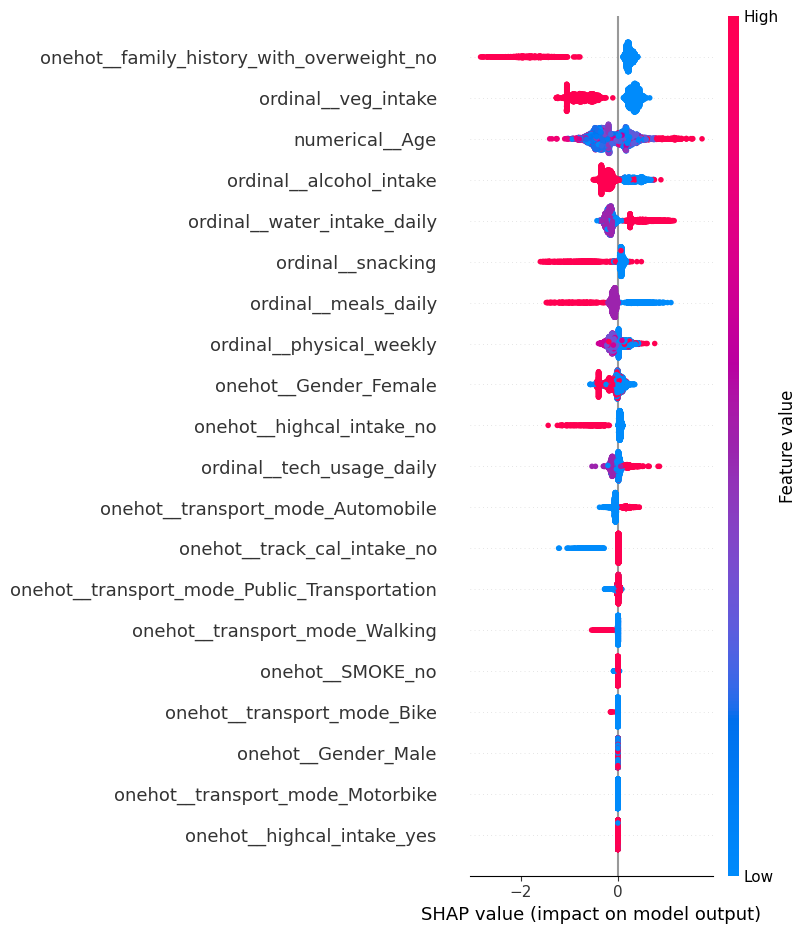

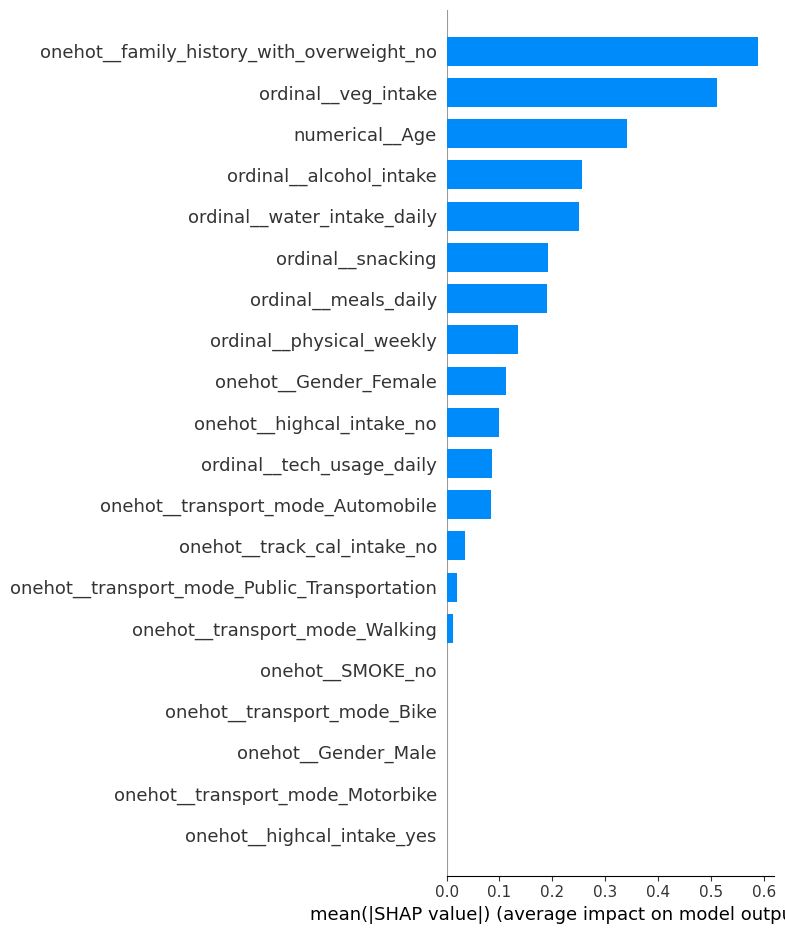

 
SHAP Values of Target: <Obesity_Severe>


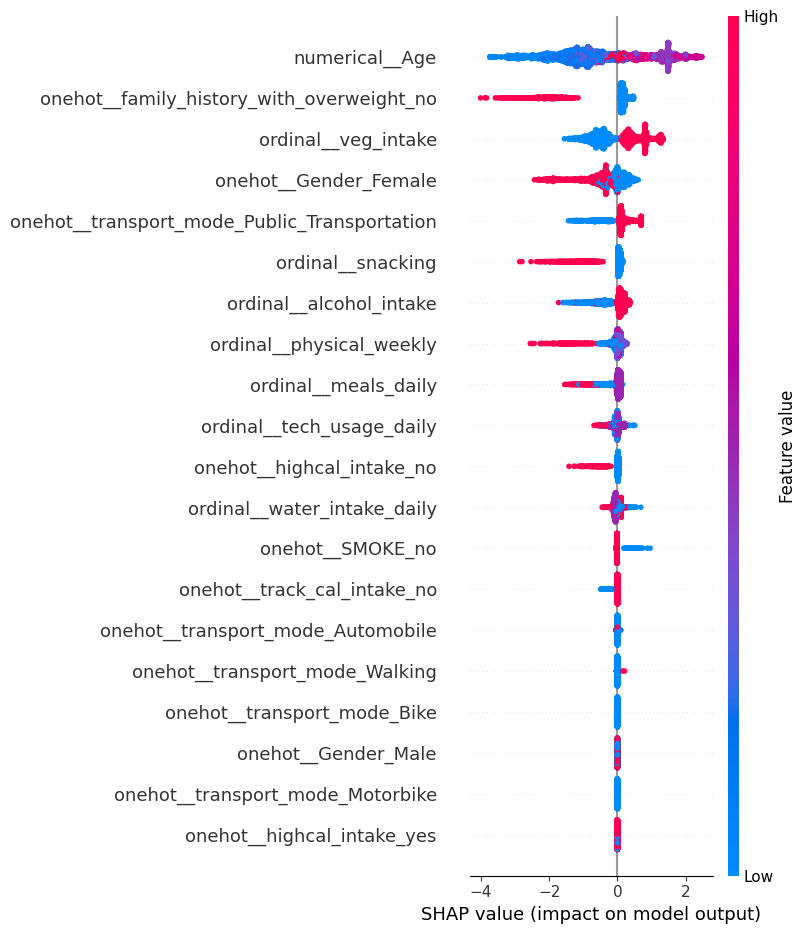

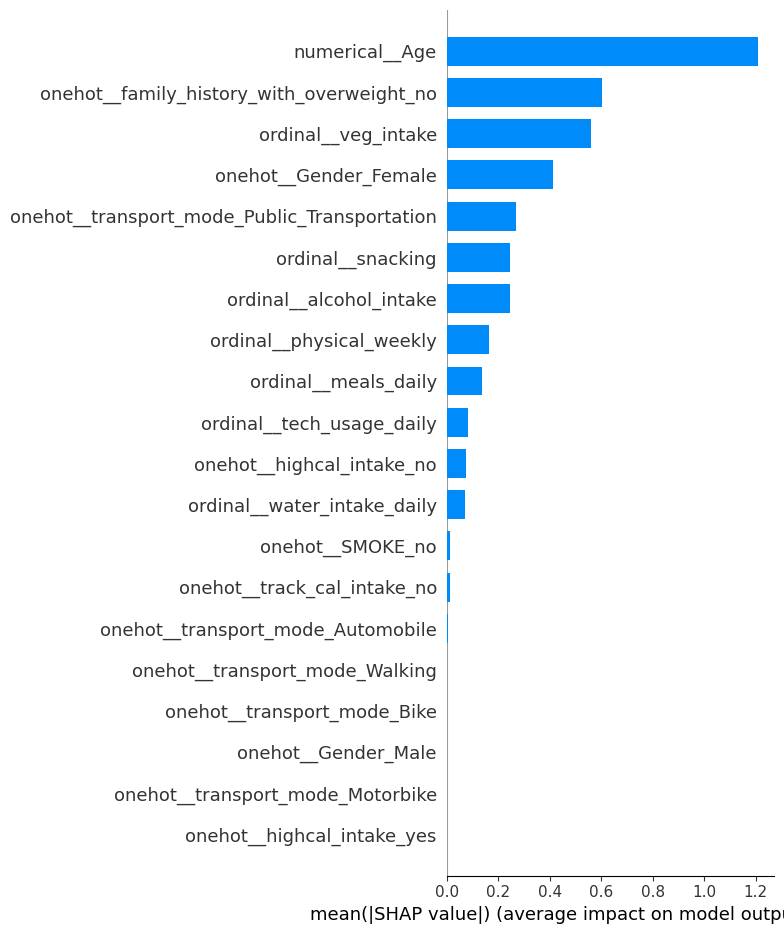

In [34]:
# Define class labels
class_labels_num = [0, 1, 2, 3, 4]
class_labels = ['Underweight', 'Normal_Weight', 'Overweight', 'Obesity', 'Obesity_Severe']


for target_label in class_labels_num:
    print(f"SHAP Values of Target: <{class_labels[target_label]}>")
    shap.summary_plot(shap_values_xgb[:,:,target_label], transformed_X_test_xgb, feature_names=feature_names_xgb)
    shap.summary_plot(shap_values_xgb[:,:,target_label], transformed_X_test_xgb, feature_names=feature_names_xgb, plot_type="bar")
    print(' ')


XAI (Global): Partial Dependence Plot (PDP)

 Vegtable Intake Frequency
**Key Observations from PDP:**


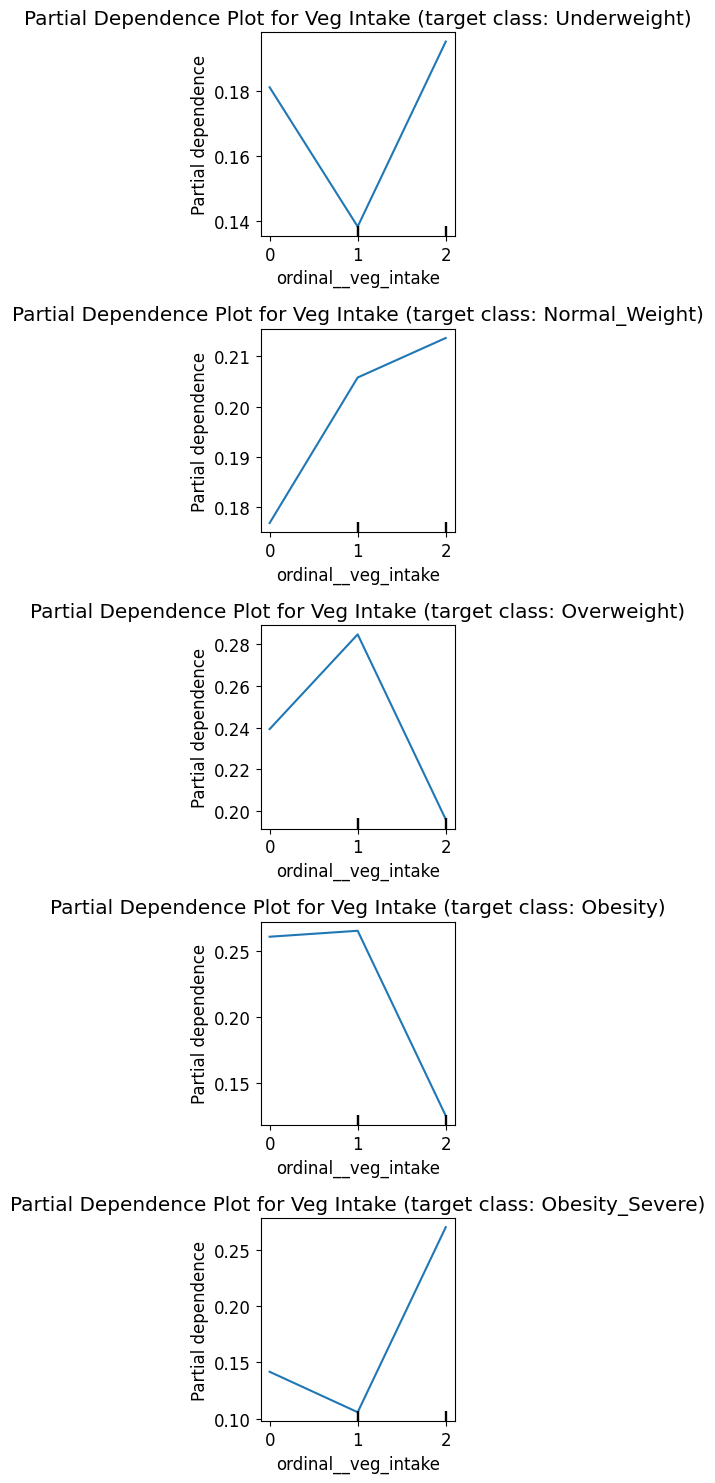

In [54]:
# Find the index of 'ordinal__veg_intake' feature in the encoded feature list
encoded_feature_names=list(feature_names)
Vegtable_intake = encoded_feature_names.index('ordinal__veg_intake')

# Plot the partial dependence for each class
fig, axs = plt.subplots(nrows=len(label_mapping), figsize=(3, 3 * len(label_mapping)),)

for i, (class_name, class_index) in enumerate(label_mapping.items()):
    ax = axs[i]
    display = PartialDependenceDisplay.from_estimator(xgb, encoder.transform(X_test), features=[Vegtable_intake], feature_names=encoded_feature_names, target=class_index, kind='average', ax=ax)
    ax.set_title(f'Partial Dependence Plot for Veg Intake (target class: {class_name})')

plt.tight_layout()
plt.show()

Family Overweight History

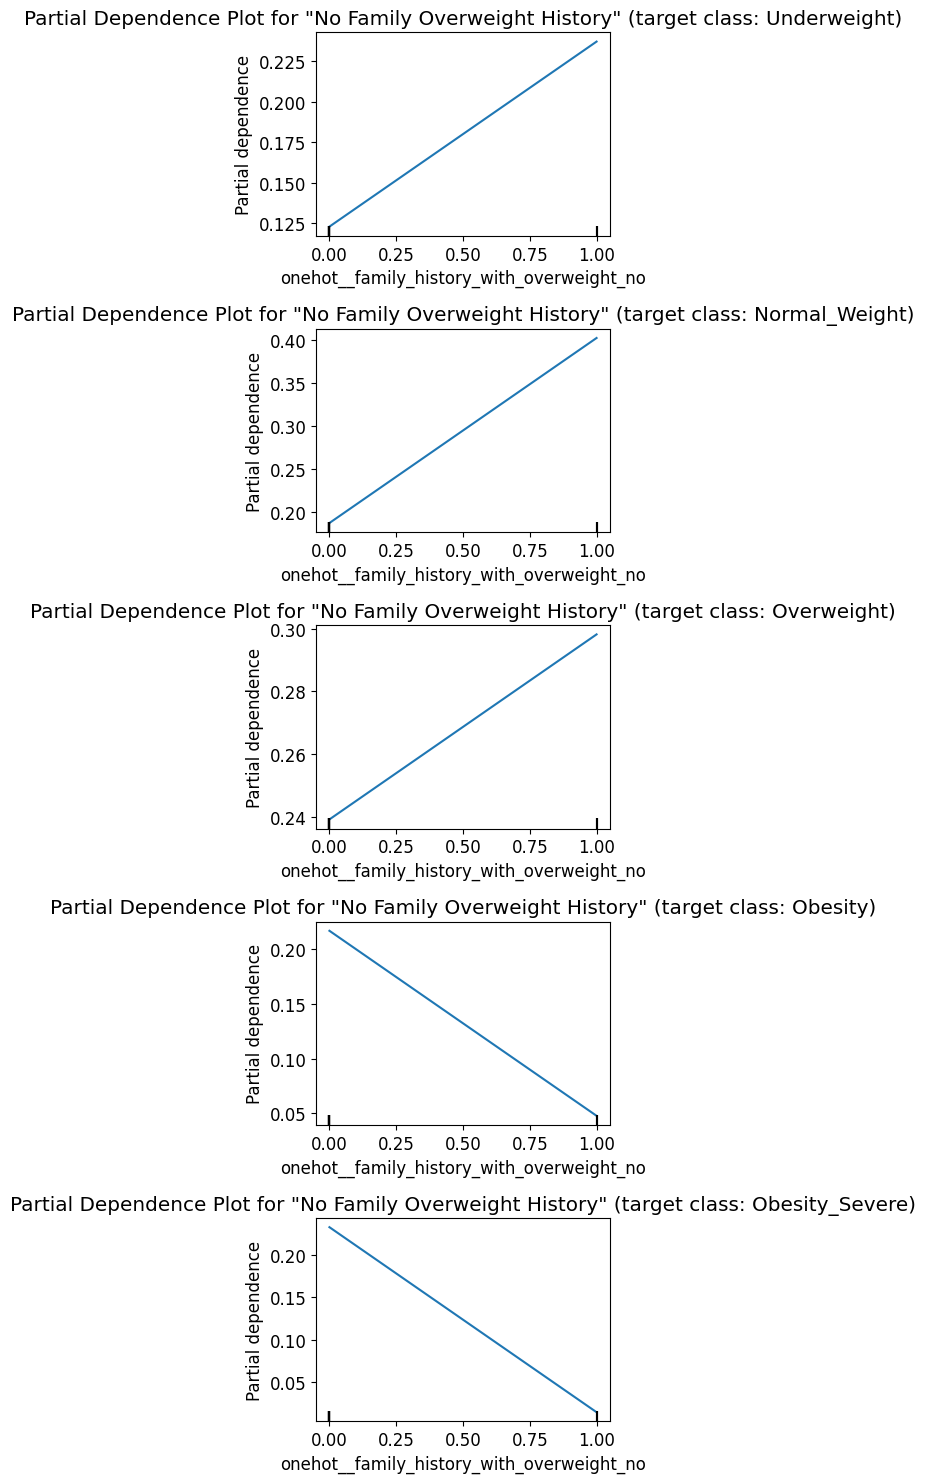

In [36]:
# Find the index of 'onehot__family_history_with_overweight_no' feature in the encoded feature list
No_Family_Overweight = encoded_feature_names.index('onehot__family_history_with_overweight_no')

# Plot the partial dependence for each class
fig, axs = plt.subplots(nrows=len(label_mapping), figsize=(4, 3 * len(label_mapping)))

for i, (class_name, class_index) in enumerate(label_mapping.items()):
    ax = axs[i]
    display = PartialDependenceDisplay.from_estimator(xgb, encoder.transform(X_test), features=[No_Family_Overweight], feature_names=encoded_feature_names, target=class_index, kind='average', ax=ax)
    ax.set_title(f'Partial Dependence Plot for "No Family Overweight History" (target class: {class_name})')

plt.tight_layout()
plt.show()

Physical Activity Frequency

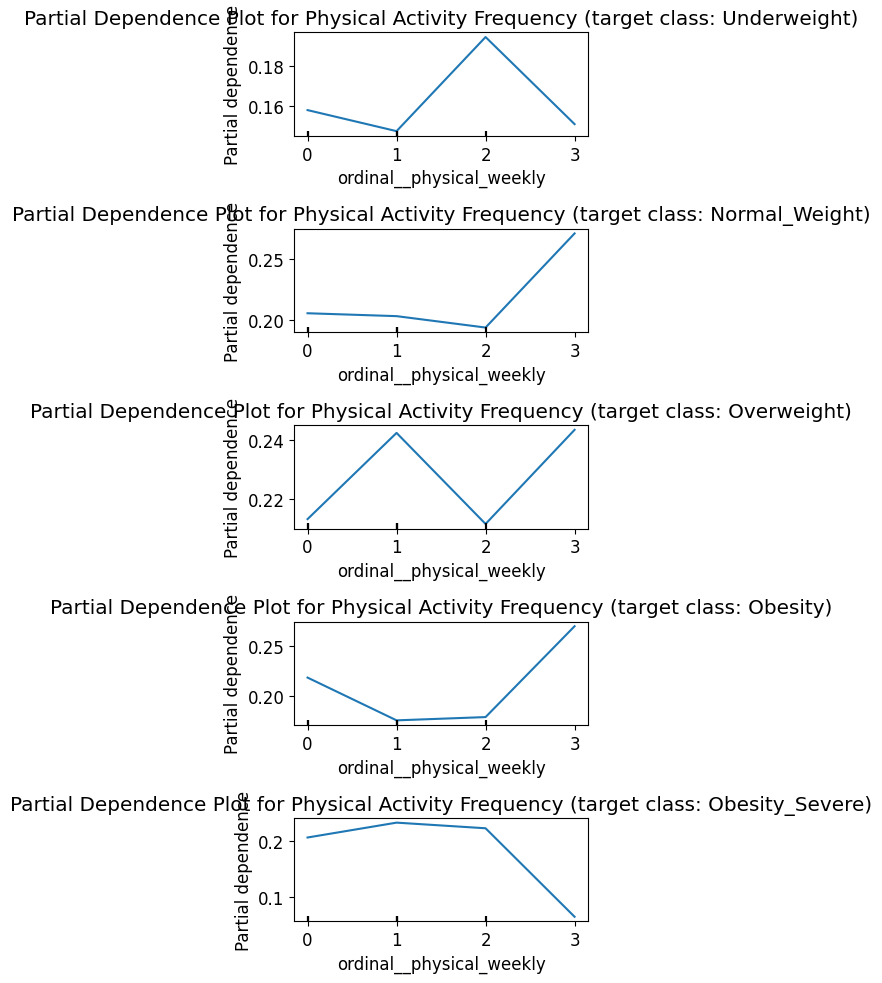

In [55]:
# Find the index of 'ordinal__physical_weekly' feature in the encoded feature list
Physical_Activity = encoded_feature_names.index('ordinal__physical_weekly')

# Plot the partial dependence for each class
fig, axs = plt.subplots(nrows=len(label_mapping), figsize=(4, 2 * len(label_mapping)))

for i, (class_name, class_index) in enumerate(label_mapping.items()):
    ax = axs[i]
    display = PartialDependenceDisplay.from_estimator(xgb, encoder.transform(X_test), features=[Physical_Activity], feature_names=encoded_feature_names, target=class_index, kind='average', ax=ax)
    ax.set_title(f'Partial Dependence Plot for Physical Activity Frequency (target class: {class_name})')

plt.tight_layout()
plt.show()

XAI (Local): LIME (Local Interpretable Model-agnostic Explanations)


 LIME Example for *Normal Weight*


In [38]:
# Select a sample instance (Normal Weight)
sample_index = 2222
sample_instance = X_test.iloc[sample_index].values.reshape(1, -1)
print(sample_instance)
print(y_test.iloc[sample_index])

[['Female' 19.0 'no' 'yes' 'Sometimes' '3 meals' 'Sometimes' 'no'
  'less than 1 litre' 'no' 'more than 4 days' '0-2 hours' 'Sometimes'
  'Public_Transportation']]
1


In [39]:
# Get the transformed features from the encoder in the pipeline
X_train_transformed = pipe_xgb.named_steps['encoder'].transform(X_train)

# Retrieve feature names after encoding
encoded_feature_names = pipe_xgb.named_steps['encoder'].get_feature_names_out()

explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_transformed,
    feature_names=encoded_feature_names,
    class_names=list(label_mapping.keys()),
    discretize_continuous=True,
    random_state=7
)

# Wrap the sample instance in a DataFrame
sample_instance_df = pd.DataFrame(sample_instance, columns=X_test.columns)

# Transform the sample instance using the encoder
sample_instance_encoded = pipe_xgb.named_steps['encoder'].transform(sample_instance_df)

# Generate explanations for the prediction of the sample instance
explanation = explainer.explain_instance(
    sample_instance_encoded[0],
    pipe_xgb.named_steps['xgb'].predict_proba,
    num_features=len(encoded_feature_names),
    labels = [y_test.iloc[sample_index]]
)

# Visualize the explanation
explanation.show_in_notebook(show_all=False)

 XAI (Local): Diverse Counterfactual Explanations (DiCE)


In [40]:
# Combine the label with the features into a dataframe
data_df_mod = pd.concat([X, y], axis=1)

# Dataset
data_dice = dice_ml.Data(dataframe=data_df_mod,
                         # For perturbation strategy
                         continuous_features=['Age'],
                         outcome_name='ObesityRisk')

# Model
# We provide the type of model as a parameter (model_type)
xgb_dice = dice_ml.Model(model=pipe_xgb, backend="sklearn", model_type='classifier')

explainer = dice_ml.Dice(data_dice,
                         xgb_dice,
                         # Random sampling, genetic algorithm, kd-tree,...
                         method="genetic")

Here, we examine an example of an individual classified under 'Obesity', and what it takes in order to move to the 'Normal_Weight' class.

In [41]:
# Single input - an obese individual
query_instances_xgb = X_test[2:3]

# Create feasible Counterfactuals
# As age & gender cannot be specifically controlled, they will be excluded from the variation
columns_to_exclude = ['Age', 'Gender']
features_to_vary = [col for col in query_instances_xgb.columns if col not in columns_to_exclude]

print("Label:", y_test[2:3])   # Label = 3 (Obesity)
query_instances_xgb

Label: 14171    3
Name: ObesityRisk, dtype: int64


Gender   Age family_history_with_overweight highcal_intake veg_intake  \
14171   Male 21.96                            yes            yes  Sometimes   

      meals_daily   snacking SMOKE water_intake_daily track_cal_intake  \
14171     3 meals  Sometimes    no  less than 1 litre               no   

      physical_weekly tech_usage_daily alcohol_intake         transport_mode  
14171          0 days        0-2 hours      Sometimes  Public_Transportation

In [42]:
cf_obese_indv = explainer.generate_counterfactuals(query_instances_xgb,
                                                   total_CFs=3,
                                                   desired_class=1,   # desired class: normal weight (1)
                                                   features_to_vary=features_to_vary
                                                  )

# Visualize it
cf_obese_indv.visualize_as_dataframe(show_only_changes=True)


100%|██████████| 1/1 [00:05<00:00,  5.18s/it]

Query instance (original outcome : 3)


Gender   Age family_history_with_overweight highcal_intake veg_intake  \
0   Male 21.96                            yes            yes  Sometimes   

  meals_daily   snacking SMOKE water_intake_daily track_cal_intake  \
0     3 meals  Sometimes    no  less than 1 litre               no   

  physical_weekly tech_usage_daily alcohol_intake         transport_mode  \
0          0 days        0-2 hours      Sometimes  Public_Transportation   

   ObesityRisk  
0            3


Diverse Counterfactual set (new outcome: 1)


Gender Age family_history_with_overweight highcal_intake veg_intake  \
0      -   -                              -              -     Always   
0      -   -                              -             no          -   
0      -   -                              -             no     Always   

  meals_daily snacking SMOKE water_intake_daily track_cal_intake  \
0           -   Always     -                  -                -   
0           -   Always     -         1-2 litres                -   
0   1-2 meals   Always     -                  -                -   

    physical_weekly tech_usage_daily alcohol_intake transport_mode ObesityRisk  
0          1-2 days                -              -        Walking           1  
0          1-2 days                -              -        Walking           1  
0  more than 4 days                -              -           Bike           1